### Imports

In [70]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter

In [ ]:
def process_psd(signal, time_start, window_time, fs=1000, plot=True):
    n_samples = window_time*fs
    start_samples = time_start*fs

    window = signal[start_samples:start_samples+n_samples]

    seconds = len(window)/fs
    t = np.arange(0, seconds, 1.0/fs)
    filter_order = 4

    # Cut-off frequencies
    fcs = [5, 70]

    w = [fc/(fs / 2) for fc in fcs] # Normalize the frequency
    b, a = butter(filter_order, w, 'bandpass')
    output = lfilter(b, a, window)


    sig_len = len(output)
    frq = np.linspace(0, fs, sig_len)
    frq = frq[:sig_len//2]
    len(frq), frq

    psd = abs(np.fft.fft(output)[:sig_len//2])*(2/sig_len)

    if plot:
        fig, ax = plt.subplots(1, figsize=(14, 4))
        ax.plot(frq, psd)
        ax.set_xlim(9, 33)
    return psd

#### Healty Marmoset
- Marmoset name: Bia

- Experimental setup: Healthy animal, fully awaken, placed inside an arena and free to move.

The dataset is structured as follows:

- 'Locomotion' : first column is the locomotion onset time, second column is the end of locomotion time

- 'noMovement': first column is the onset time for a period in which the animal was completely quite, second column is the end time of the quiet period
 
- 'X','Y': animal coordinates in the arena (in metres)

- 'spikes': single-neuron spike times (after the sorting procedure)

- 'LFP': LFP time series for each recording channel (64 channels), sampling frequency is 1000 Hz

- 'channelsLeft': cell array, each field contains the channel indexes for each LFP region in the left hemisphere, with respect to the `areaNames` variable. For example, channelsLeft{1}= [1     2     3     4     5     6     7    17    18], which means that LFP{1} is related to M1. 

- 'channelsRight': same as channelsLeft, but for the right hemisphere

- 'areaNames': cell array containing the recording sites. For Bia, we recorded from M1, PUT, GPE, and GPI.

In [16]:
fs = 1000
healthy_data = loadmat('datasets/healthy/Bia_1.mat', squeeze_me=True)
healthy_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'channelsLeft', 'channelsRight', 'areaNames', 'Locomotion', 'noMovement', 'spikes', 'LFP', 'X', 'Y'])

In [17]:
healthy_data.get('areaNames')

array(['M1', 'PUT', 'GPE', 'GPI'], dtype=object)

In [18]:
lfp = healthy_data.get('LFP')
areas = healthy_data.get('areaNames')
channels_left = healthy_data.get('channelsLeft')
channels_right = healthy_data.get('channelsRight')
d = {areas[i]:list(np.append(channels_left[i], channels_right[i])) for i in range(len(areas))}
d

{'M1': [1, 2, 3, 4, 5, 6, 7, 17, 18, 42, 43, 44, 45, 46, 47, 48, 63, 64],
 'PUT': [8, 9, 10, 11, 12, 13, 14, 15, 16, 33, 34, 35, 36, 37, 38, 39, 40, 41],
 'GPE': [19, 20, 21, 22, 23, 24, 57, 58, 59, 60, 61, 62],
 'GPI': [25, 26, 27, 28, 29, 30, 31, 32, 49, 50, 51, 52, 53, 54, 55, 56]}

In [19]:
m1 = np.array([lfp[i-1] for i in d.get('M1')])
put = np.array([lfp[i-1] for i in d.get('PUT')])
gpe = np.array([lfp[i-1] for i in d.get('GPE')])
gpi = np.array([lfp[i-1] for i in d.get('GPI')])

In [20]:
mean_signal = np.mean(m1*1000, axis=0)

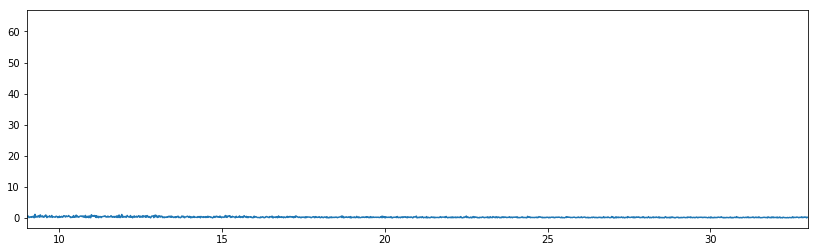

In [24]:
five_sec_samples = 60*fs
window = mean_signal[600*fs:600*fs+five_sec_samples]
plot_fft(window)

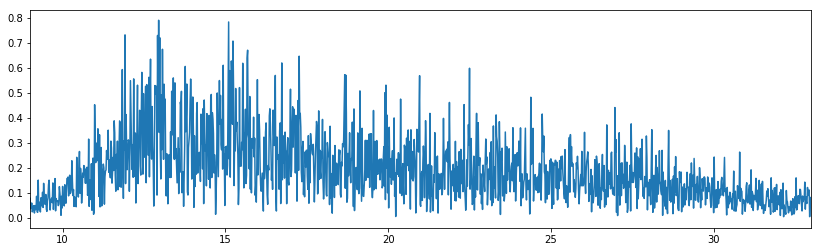

In [25]:
seconds = len(window)/fs
t = np.arange(0, seconds, 1.0/fs)
filter_order = 4

# Cut-off frequencies
fcs = [12, 30]

w = [fc/(fs / 2) for fc in fcs] # Normalize the frequency
b, a = butter(filter_order, w, 'bandpass')
output = lfilter(b, a, window)

plot_fft(output)

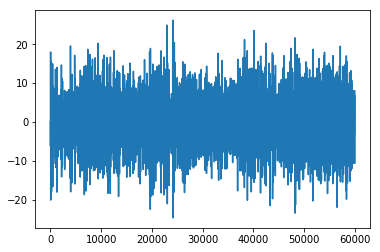

In [26]:
plt.figure()
plt.plot(output)

## Non healthy marmoset

Areas:
- Putâmen
- Motor
- Globo pálido externo
- Globo pálido interno

In [41]:
data = loadmat('datasets/injuried/DATA_FP_Paty_20150203_baseline.mat', squeeze_me=True,  struct_as_record=False)
data.keys()
injuried_data = data.get('data')

In [42]:
injuried_data.lfp_id

array(['SPKC19', 'MI01L', 'MI02L', 'MI03L', 'MI04L', 'MI05L', 'PUT06L',
       'PUT07L', 'PUT08L', 'PUT09L', 'PUT10L', 'PUT11L', 'GPe12L',
       'GPe13L', 'GPe14L', 'GPe15L', 'GPi16L', 'GPi17L', 'GPi18L',
       'GPi19L', 'GPi20L', 'VL21L', 'VL22L', 'STN23L', 'STN24L', 'STN25L',
       'STN26L', 'VL27L', 'VL28L', 'VPL29L', 'VPL30L', 'VPL31L', 'VPL32L',
       'VL01R', 'VL02R', 'STN03R', 'STN04R', 'STN05R', 'STN06R', 'VL07R',
       'VL08R', 'VPL09R', 'VPL10R', 'VPL11R', 'VPL12R', 'GPi13R',
       'GPi14R', 'GPi15R', 'GPi16R', 'GPi17R', 'GPe18R', 'GPe19R',
       'GPe20R', 'GPe21R', 'PUT22R', 'PUT23R', 'PUT24R', 'PUT25R',
       'PUT26R', 'PUT27R', 'MI28R', 'MI29R', 'MI30R', 'MI31R', 'MI32R'],
      dtype=object)

In [43]:
### Getting channel_indexes manually according to previous lfp_id (previous_cell output). The SPKC19 is ignored
d = {
    'MI_L': [1, 2, 3, 4, 5],
    'PUT_L': [6, 7, 8, 9, 10, 11],
    'GPE_L': [12, 13, 14, 15],
    'GPI_L': [16, 17, 18, 19, 20],
    'VL_L': [21, 22, 27, 28, 29, 30, 31, 32],
    'STN_L': [23, 24, 25, 26],
    'MI_R': [60, 61, 62, 63, 64],
    'PUT_R': [54, 55, 56, 57, 58, 59],
    'GPE_R': [50, 51, 52, 53],
    'GPI_R': [45, 46, 47, 48, 49],
    'VL_R': [33, 34, 39, 40, 41, 42, 43, 44],
    'STN_R': [35, 36, 37, 38]
}

In [60]:
# Since the healthy data doesn't have VL and STN, they will be ignored
m1_left = np.array([injuried_data.lfp_samples[i] for i in d.get('MI_L')])
put_left = np.array([injuried_data.lfp_samples[i] for i in d.get('PUT_L')])
gpe_left = np.array([injuried_data.lfp_samples[i] for i in d.get('GPE_L')])
gpi_left = np.array([injuried_data.lfp_samples[i] for i in d.get('GPI_L')])

m1_right = np.array([injuried_data.lfp_samples[i] for i in d.get('MI_R')])
put_right = np.array([injuried_data.lfp_samples[i] for i in d.get('PUT_R')])
gpe_right = np.array([injuried_data.lfp_samples[i] for i in d.get('GPE_R')])
gpi_right = np.array([injuried_data.lfp_samples[i] for i in d.get('GPI_R')])

In [57]:
mean_signal = np.mean(gpe_right*1000, axis=0)

In [63]:
mean_signal = gpe_right[0]

In [74]:
signal = mean_signal

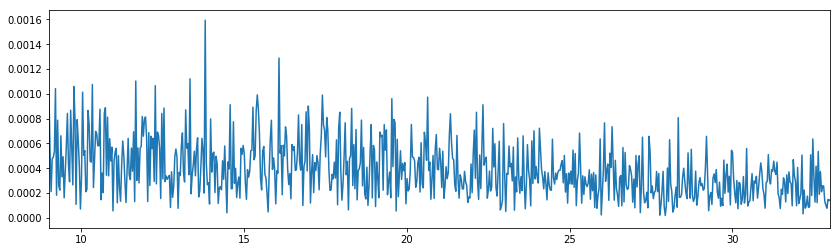

In [82]:
psd = process_psd(signal, 20, 30)